<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [203]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [204]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [205]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [206]:
w_init = initializers.glorot_normal()
b_init = initializers.Zeros()

In [207]:
model = tf.keras.Sequential()

drop_out = 0.30
lern_rat = 0.001
neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 1, activation='relu', kernel_initializer=w_init, bias_initializer=b_init)) #, kernel_regularizer=regularizers.l2(lern_rat)
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='tanh'))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

# model.add(layers.Dense(neurons * 2, activation='relu'))
# model.add(BatchNormalization())
# model.add(layers.Dropout(drop_out * 2))

model.add(layers.Dense(10, activation='softmax'))

In [208]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 127ms/step


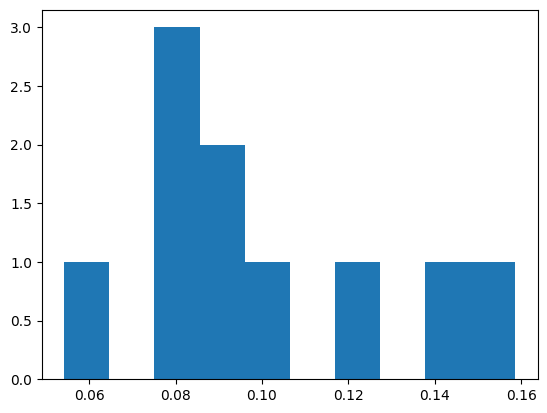

In [209]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [210]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [211]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [ ]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=400,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc],
                    verbose=1, #многословие
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/400
391/391 [==============================] - 3s 7ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.4380 - val_sparse_categorical_accuracy: 0.8424
Epoch 2/400
391/391 [==============================] - 2s 6ms/step - loss: 0.5077 - sparse_categorical_accuracy: 0.8124 - val_loss: 0.4080 - val_sparse_categorical_accuracy: 0.8472
Epoch 3/400
391/391 [==============================] - 3s 7ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8279 - val_loss: 0.3882 - val_sparse_categorical_accuracy: 0.8564
Epoch 4/400
391/391 [==============================] - 3s 7ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.3680 - val_sparse_categorical_accuracy: 0.8596
Epoch 5/400
391/391 [==============================] - 3s 7ms/step - loss: 0.4259 - sparse_categorical_accuracy: 0.8412 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.8657
Epoch 6/400
391/391 [==============================] - 2s 6ms/step - loss: 0.4139 - sparse_cate

In [ ]:
print('\nhistory dict:', list(history.history.keys()))

In [ ]:
result = model.evaluate(x_test, y_test)
print(result)

In [ ]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

In [ ]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.94)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(x_test)

In [ ]:
predictions[0]

In [ ]:
model.summary()